<h1><font color="#113D68" size=6>Deep Learning Avanzado con Python y Keras</font></h1>
<h1><font color="#113D68" size=5>Leandro Martín Rognoni</font></h1>

<br><br>
<div style="text-align: right">
 
</div>

<a id="section0"></a>
# <font color="#004D7F" size=5> Contexto</font>

 * Definición de un grafo
* Entrenamiento de una red
* Capas de la red
* Carga de grandes bases de datos
* Data augmentation

Trabajaremos con dos bases de datos:
* MNIST: la base de datos de números nos servirá para definir los conceptos básicos. 
* VGG 102 Category Flowers: la base de datos utilizada en las prácticas anteriores, que consiste en un problema de clasificación de imágenes y con el que veremos redes con capas más complejas, como cargar grandes bases de datos y el data augmentation.

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import keras

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
SEED = 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)

<a id="section2.1"></a>
# <font color="#004D7F" size=5> MNIST</font>

MNIST es una base de datos que consta de imágenes de tamaño 28x28 de dígitos escritos a mano que van del 0 al 9 y que han sido etiquetadas con el número representado en la imagen. Inicialmente, tenemos 60.000 imágenes en el conjunto de train y 10.000 en el de test, sin embargo, el conjunto de train lo vamos a partir en entrenamiento y validación, siguiendo las prácticas anteriores.

In [52]:
# keras ya nos da una función con la que cargar esta base de datos
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, y_train_valid, test_size=0.1, random_state=SEED, stratify=y_train_valid)

print("Dimensiones del conjunto de características de train: {}".format(x_train.shape))
print("Dimensiones del conjunto de etiquetas de train: {}".format(y_train.shape))
print()
print("Dimensiones del conjunto de características de valid: {}".format(x_valid.shape))
print("Dimensiones del conjunto de etiquetas de valid: {}".format(y_valid.shape))
print()
print("Dimensiones del conjunto de características de test: {}".format(x_test.shape))
print("Dimensiones del conjunto de etiquetas de test: {}".format(y_test.shape))

Dimensiones del conjunto de características de train: (54000, 28, 28)
Dimensiones del conjunto de etiquetas de train: (54000,)

Dimensiones del conjunto de características de valid: (6000, 28, 28)
Dimensiones del conjunto de etiquetas de valid: (6000,)

Dimensiones del conjunto de características de test: (10000, 28, 28)
Dimensiones del conjunto de etiquetas de test: (10000,)


In [53]:
def show_images(images, gray=True):
    fig=plt.figure(figsize=(8, 8))
    index = np.random.randint(len(images), size=100)
    for i in range(100):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        if gray:
            color = 'gray'
        else:
            color = None
        plt.imshow(images[index[i]], cmap=color)
    plt.show()

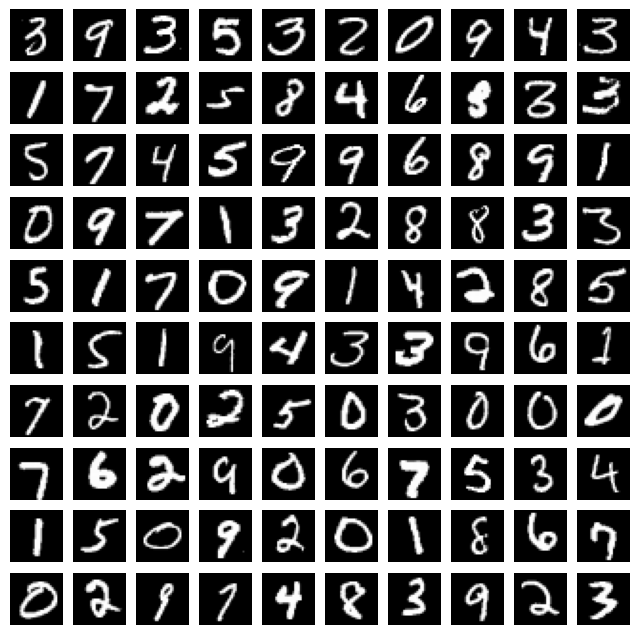

In [55]:
show_images(x_train)

Es mejor tener las imágenes como un vector de características, por lo que vamos a "aplanar" nuestras imágenes de train y test en una matriz de 2 dimensiones. Además, vamos a normalizar los valores entre 0 y 1, para ello dividimos entre 255, ya que los valores en escala de grises van del 0 al 255.

Al igual que en todos los problemas multiclase en deep learning, hay que convertir los valores a codificación **one hot** para poder trabajar con ellos. Lo vamos a dejar ya preparado con la función `to_categorical` de `keras.utils`.

In [56]:
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],-1)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
print("Dimensiones del conjunto de características de train aplanadas: {}".format(x_train.shape))
print("Dimensiones del conjunto de etiquetas de train en one hot: {}".format(y_train.shape))
print()

x_valid = x_valid.astype('float32')
x_valid /= 255
x_valid = x_valid.reshape(x_valid.shape[0],-1)
y_valid = keras.utils.to_categorical(y_valid, num_classes=10)
print("Dimensiones del conjunto de características de train aplanadas: {}".format(x_valid.shape))
print("Dimensiones del conjunto de etiquetas de train en one hot: {}".format(y_valid.shape))
print()


x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0],-1)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
print("Dimensiones del conjunto de características de test aplanadas: {}".format(x_test.shape))
print("Dimensiones del conjunto de etiquetas de test en one hot: {}".format(y_test.shape))

Dimensiones del conjunto de características de train aplanadas: (54000, 784)
Dimensiones del conjunto de etiquetas de train en one hot: (54000, 10)

Dimensiones del conjunto de características de train aplanadas: (6000, 784)
Dimensiones del conjunto de etiquetas de train en one hot: (6000, 10)

Dimensiones del conjunto de características de test aplanadas: (10000, 784)
Dimensiones del conjunto de etiquetas de test en one hot: (10000, 10)


<a id="section2.2"></a>
# <font color="#004D7F" size=5>Creación de una Red Neuronal Secuencial para Clasificación Multiclase </font>

In [458]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(15, input_shape=(784,), activation='relu')) # Primera capa oculta
#Se agregó dropout para desactivar neuronas para prevenir sobreajuste 
model.add(Dropout(0.01))

model.add(Dense(15, activation='relu')) # Segunda capa oculta
model.add(Dropout(0.01))

model.add(Dense(10, activation='softmax')) # Salida (10 clases)

En la primera capa se ha añadido `input_shape`. Esto hay que hacerlo obligatoriamente en la primera y sólo en la primera capa de todos los modelos, indicando el tamaño de la entrada. Este valor es 784 (28*28) que corresponde con el número de pixels de las imágenes de MNIST.

<a id="section2.3"></a>
# <font color="#004D7F" size=5>Entrenamiento</font>

Se define el aprendizaje, es decir, la función de perdida (`loss`) y el optimizador. Esta función tiene como parámetros de entrada `loss` y `optimizer`, para usar una función concreta con sus valores por defecto, o un objeto que defina la función. Además, podemos añadir diferentes métricas que se calcularán durante el proceso de aprendizaje y de validación.


In [459]:
# Ejemplo con las funciones predefinidas y con valores por defecto
model.compile(loss='categorical_crossentropy', optimizer='sgd')
# Podemos añadir métricas  
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

Ajustar automáticamente la tasa de aprendizaje "ExponentialDecay"

In [460]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    #staircase=True,
    decay_rate=1e-6)

In [461]:
from keras.optimizers import SGD
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

"Fit"tiene como parámetros de entrada la matriz de características, las clases, el número de epocas, tamaño del batch y devuelve un objeto History con información sobre el entrenamiento, como el `loss` obtenido o las `metrics` que hayamos indicado en `compile`.

In [462]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=2048)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.3788 - loss: 1.7452 - val_acc: 0.8432 - val_loss: 0.5278
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8481 - loss: 0.5014 - val_acc: 0.8872 - val_loss: 0.3710
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8850 - loss: 0.3808 - val_acc: 0.9045 - val_loss: 0.3196
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8996 - loss: 0.3337 - val_acc: 0.9118 - val_loss: 0.2945
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9072 - loss: 0.3053 - val_acc: 0.9218 - val_loss: 0.2750
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9136 - loss: 0.2857 - val_acc: 0.9248 - val_loss: 0.2625
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9173 - loss: 0.2724 - val_acc: 0.9292 - val_loss: 0.2515
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9205 - loss: 0.2615 - val_acc: 0.9320 - val_loss: 0.2437
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9231 - loss:

In [287]:
print(history.history.keys())

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


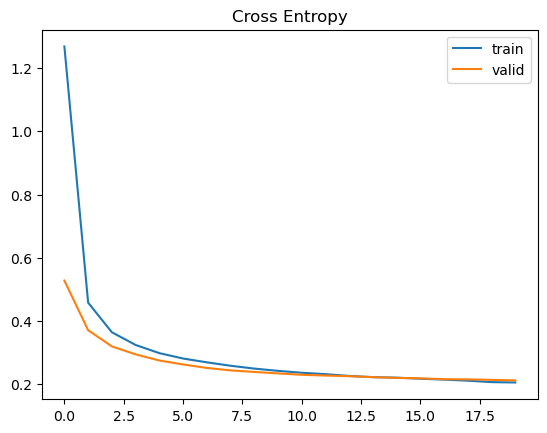

In [463]:
# Cross entropy es una función de pérdida que compara la distribución de probabilidad predicha por el modelo con la distribución real de los datos.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
# Se representan dos curvas a lo largo de las epocas del entrenamiento del modelo:

plt.show()

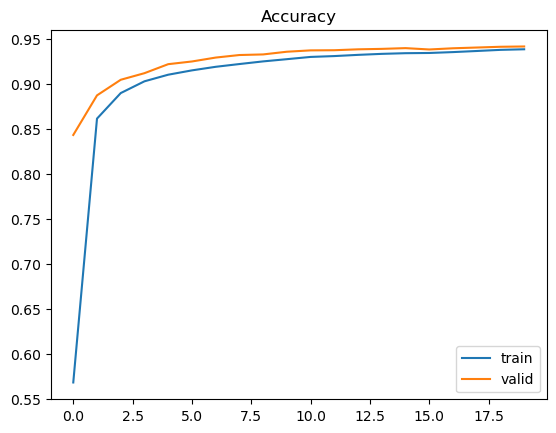

In [464]:
#   la evolución del accuracy a través de los epocas
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

<a id="section2.4"></a>
# <font color="#004D7F" size=5>Predicción y test</font>


* `predict`: la salida de la última capa.
* `predict_proba`: las probabilidades normalizadas de las salidas (si nuestra red ya incluye softmax al final, el resultado es el mismo que la función anterior).
* `predict_class`: la clase predicha 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


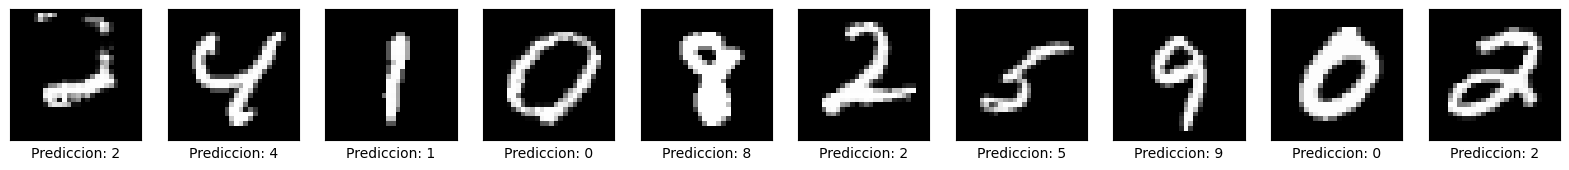

In [470]:
#predictions = model.predict_classes(x_test)

#si la probabilidad es mayor que 0.5,se considera que el ejemplo pertenece a la clase positiva (1),
# y si es menor o igual a 0.5, se considera que pertenece a la clase negativa (0).
predictions = (model.predict(x_test) > 0.5).astype("int32")
#Se utiliza para obtener la clase con la probabilidad más alta para cada ejemplo
predictions = np.argmax(predictions, axis=1)
# Mostramos algunos digitos con las clases predichas
fig=plt.figure(figsize=(20, 8))
index = np.random.randint(len(x_test), size=10)
for i in range(10):
    fig_i = fig.add_subplot(1, 10, i+1)
    fig_i.set_xticks(())
    fig_i.set_yticks(())
    fig_i.set_xlabel("Prediccion: {}".format(predictions[index[i]]))
    plt.imshow(x_test[index[i]].reshape((28,28)), cmap='gray')
plt.show()

Obtener algunos resultados sobre el test, utilizamos `evaluate`, que nos devolverá los valores `loss` y las `metrics` para un conjunto de test.

In [471]:
score = model.evaluate(x_test, y_test)
print()
print("Loss: {}\nAccuracy: {}".format(score[0],score[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9306 - loss: 0.2201

Loss: 0.18935228884220123
Accuracy: 0.9420999884605408


<a id="section3.1"></a>
# <font color="#004D7F" size=5> VGG 102 Category Flowers</font>

Es un problema de clasificación de imágenes donde la clase es una de las 102 posibles etiquetas que representan flores que aparecen en la foto.

In [1]:
import sys
import time
import urllib.request
import tarfile

progress_size = 0  # Declaración global de la variable progress_size

def reporthook(count, block_size, total_size):
    global start_time, progress_size
    if count == 0:
        start_time = time.time()
        progress_size = 0  # Inicializar progress_size en 0 al inicio
        return
    duration = time.time() - start_time
    if duration == 0:
        speed = 0
    else:
        progress_size = int(count * block_size)
        speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

# Download and extract
data_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
urllib.request.urlretrieve(data_url, 'vgg102flowers.tar.gz', reporthook)
tar = tarfile.open('vgg102flowers.tar.gz', "r:gz")
tar.extractall()
tar.close()

labels_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
urllib.request.urlretrieve(labels_url, 'vgg102flowers_targets.mat', reporthook)

...92%, 303 MB, 7199 KB/s, 43 seconds passed

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...1631%, 0 MB, 2665 KB/s, 0 seconds passeded

('vgg102flowers_targets.mat', <http.client.HTTPMessage at 0x1d5ad0e3810>)

In [6]:
 
import numpy as np
from glob import glob
from scipy.io import loadmat
# Files
files = np.array(sorted(glob("jpg/*")))

# Targets
mat = loadmat('vgg102flowers_targets.mat')
labels = mat['labels'][0] - 1

# Random permute (we can also shuffle the dataset)
idx = np.random.permutation(len(files))
files = files[idx]
labels = labels[idx]

# Load classes names
# From: https://github.com/jimgoo/caffe-oxford102
names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

print("Loaded %d files." % len(files))

Loaded 8189 files.


In [7]:
from sklearn.model_selection import train_test_split

# Train/valid/test split
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, random_state=1234, stratify=labels)

train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.25, random_state=5678, stratify=train_valid_labels)

print("Train: ", train_files.shape)
print("Valid: ", valid_files.shape)
print("Test: ", test_files.shape)

del train_valid_files, train_valid_labels

Train:  (4913,)
Valid:  (1638,)
Test:  (1638,)


Hasta aquí todo es igual que en la práctica 3 de preprocesamiento de imágenes. Ahora vamos a utilizar las funciones de **Keras** para preparar un iterador que recorra las imágenes de la carpeta y así poder entrenar nuestra red neuronal. Extisten varias opciones para realizar este iterador, así como formas de hacer data augmentation y de extender dichas opciones a las predefinidas en Keras. Se recomienda echar un vistazo a la página de [procesamiento de imágenes.](https://keras.io/preprocessing/image/)

En este caso vamos a empezar leyendo de un DataFrame de pandas con dos columnas, una con la ruta a la imagen y otra con la etiqueta correspondiente. Todo esto lo haremos a través de la clase `ImageDataGenerator`, que se divide en dos partes como veremos a continuación.

In [8]:
import pandas as pd


train_frame = pd.DataFrame(np.array([train_files, train_labels]).T, columns=['files','labels'])
valid_frame = pd.DataFrame(np.array([valid_files, valid_labels]).T, columns=['files','labels'])
test_frame = pd.DataFrame(np.array([test_files, test_labels]).T, columns=['files','labels'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(100, 120), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=True)

valid_iter = valid_datagen.flow_from_dataframe(valid_frame, 
                                               x_col='files', 
                                               y_col='labels', 
                                               target_size=(100, 120), 
                                               class_mode='categorical',
                                               batch_size=32, 
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame, 
                                             x_col='files', 
                                             y_col='labels', 
                                             target_size=(100, 120), 
                                             class_mode='categorical',
                                             batch_size=32, 
                                             shuffle=False)

Found 4913 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


<a id="section3.2"></a>
# <font color="#004D7F" size=5> Red Convolucional</font>

 
* 1 o varios bloques convolucionales compuestos, que incluye:
* 1 o varias capas convolucionales, todas con activación ReLU
* 1 capa Max Pooling
* 1 o varias capas densas o `Fully connected` con activación ReLU
* 1 capa de salida con softmax

 

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# definimos el modelo lineal
model = Sequential()

# recordemos que en la primera capa hay que indicar el tamaño de la entrada
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Antes de poder pasar de la capa convolucional a la densa, es necesario "aplanar" la salida, por eso se usa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# finalmente creamos la capa de salida, con el tamaño de las etiquetas de nuestro problema
model.add(Dense(102, activation='softmax'))

C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Antes de continuar, vamos a ver unas funciones de Keras especialmente útiles para ver ciertos aspectos de las redes.

<a id="section3.2.1"></a>
## <font color="#004D7F" size=4>summary</font>
Esta función nos muestra una tabla con las capas que forman nuestra red, asi como su tamaño y el número de parámetros a entrenar por capa.

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 116, 32)    │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    38,929,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │       104,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,087,654 (149.11 MB)

 Trainable params: 39,087,654 (149.11 MB)

 Non-trainable params: 0 (0.00 B)

<a id="section3.2.2"></a>
## <font color="#004D7F" size=4>get_config</font>
Esta función nos devuelve la configuración de una red, en una estructura de diccionario y que se puede utilizar para inicializar otros modelos. 

In [14]:
model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 100, 120, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (5, 5),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
  

<a id="section3.3"></a>
# <font color="#004D7F" size=5>Entrenamiento y validación</font>

En este punto vamos a entrenar la red igual que hicimos en el problema de MNIST. Como estamos trabajando con un iterador, deberemos llamar a la función `fit_generator`, que se encarga de realizar el mismo proceso que `fit` pero con un generador. Además, deberemos indicar el numero de pasos o `steps` que tiene una `epoch`. Esto es, el número total de imágenes entre el tamaño del batch.

In [15]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    #staircase=True,
    decay_rate=1e-6)

In [16]:
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])


history = model.fit(train_iter, steps_per_epoch = train_frame.shape[0]//train_iter.batch_size,
                              epochs=10, validation_data=valid_iter, 
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/10


C:\Users\Lea\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 89s 564ms/step - acc: 0.0267 - loss: 4.6581 - val_acc: 0.0319 - val_loss: 4.5071
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - acc: 0.0312 - loss: 4.6603 - val_acc: 0.0000e+00 - val_loss: 4.5101
Epoch 3/10


C:\Users\Lea\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


153/153 ━━━━━━━━━━━━━━━━━━━━ 86s 553ms/step - acc: 0.0293 - loss: 4.5163 - val_acc: 0.0239 - val_loss: 4.5027
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - acc: 0.0000e+00 - loss: 4.5397 - val_acc: 0.0000e+00 - val_loss: 4.4825
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 85s 552ms/step - acc: 0.0306 - loss: 4.5111 - val_acc: 0.0319 - val_loss: 4.5012
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - acc: 0.0938 - loss: 4.3898 - val_acc: 0.0000e+00 - val_loss: 4.4732
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 86s 555ms/step - acc: 0.0345 - loss: 4.4979 - val_acc: 0.0319 - val_loss: 4.4998
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - acc: 0.0938 - loss: 4.4070 - val_acc: 0.0000e+00 - val_loss: 4.4888
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 86s 555ms/step - acc: 0.0306 - loss: 4.4935 - val_acc: 0.0319 - val_loss: 4.5007
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - acc: 0.0000e+00 - loss: 4.5325 - val_acc: 0.0000e+00 - val_loss: 4.4866


In [17]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - acc: 0.0332 - loss: 4.5003
loss en validación: 4.500723838806152 
accuracy en validación: 0.03186274692416191
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - acc: 0.0320 - loss: 4.4979
loss en test: 4.501021862030029 
accuracy en test: 0.03125


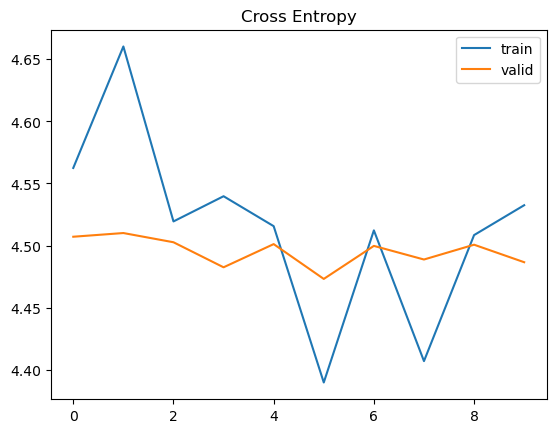

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

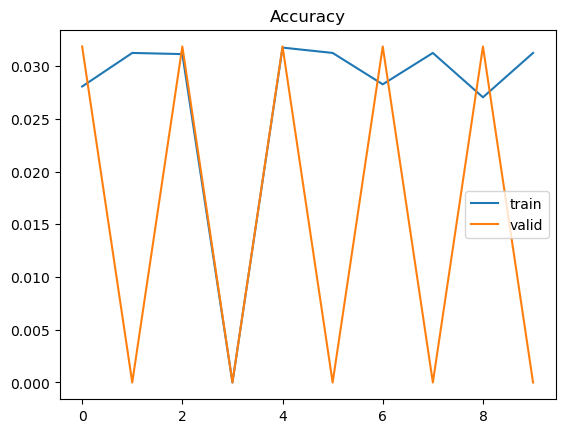

In [53]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

<a id="section3.4"></a>
# <font color="#004D7F" size=5>Data Augmentation</font>



* Primero, en el constructor definimos las operaciones o modificaciones que vamos a realizar a los datos.
* Segundo, con las funciones `flow` generamos un iterador que se va a encargar de leer los datos. Por eso los parámetros de entrada de las funciones `flow` indican donde se encuentran las imágenes, el formato de estas y el tamaño de salida. También indicamos aquí el tamaño del batch del iterador.

Con esto el iterador obtenido primero cargará el batch de datos según lo indicado en los parámetros de las funicones `flow` y luego aplicará las funciones definidas en el constructor de [`ImageDataGenerator`](https://keras.io/preprocessing/image/). Estas funciones consisten en data augmentation estocástico, es decir, cada operación que se ha indicado se aplica de forma aleatoria a las diferentes datos, en este caso imágenes, de los batches.

In [21]:
train_datagen_augmented = ImageDataGenerator(rescale=1./255, horizontal_flip = True, vertical_flip = True, rotation_range = 10)

train_iter_augmented = train_datagen_augmented.flow_from_dataframe(train_frame, 
                                                                   x_col='files', 
                                                                   y_col='labels', 
                                                                   target_size=(100, 120), 
                                                                   class_mode='categorical',
                                                                   batch_size=32, 
                                                                   shuffle=True)

Found 4913 validated image filenames belonging to 102 classes.


In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# definimos el modelo lineal
model = Sequential()

# el primer bloque convolucional completo, formado de dos capas convolucionales con activación relu, 
# un max pooling y un dropout.

# recordemos que en la primera capa hay que indicar el tamaño de la entrada
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Antes de poder pasar de la capa convolucional a la densa, es necesario "aplanar" la salida, por eso se usa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# finalmente creamos la capa de salida, con el tamaño de las etiquetas de nuestro problema
model.add(Dense(102, activation='softmax'))

In [40]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    #staircase=True,
    decay_rate=1e-6)

In [41]:
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

history = model.fit(train_iter_augmented,
                              steps_per_epoch = train_frame.shape[0]//train_iter_augmented.batch_size,
                              epochs=10,
                              validation_data=valid_iter, 
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 111s 702ms/step - acc: 0.0250 - loss: 4.5714 - val_acc: 0.0319 - val_loss: 4.5064
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - acc: 0.0312 - loss: 4.5064 - val_acc: 0.0000e+00 - val_loss: 4.4816
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 106s 683ms/step - acc: 0.0323 - loss: 4.4982 - val_acc: 0.0319 - val_loss: 4.5017
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - acc: 0.0000e+00 - loss: 4.4954 - val_acc: 0.0000e+00 - val_loss: 4.4586
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 106s 676ms/step - acc: 0.0323 - loss: 4.5069 - val_acc: 0.0319 - val_loss: 4.5002
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - acc: 0.0312 - loss: 4.6327 - val_acc: 0.0000e+00 - val_loss: 4.4805
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 114s 734ms/step - acc: 0.0299 - loss: 4.4984 - val_acc: 0.0319 - val_loss: 4.5015
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - acc: 0.0312 - loss: 4.4617 - val_acc: 0.0000e+00 - val_loss: 4.4861
Epoch 9/10
1

In [42]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - acc: 0.0332 - loss: 4.4974
loss en validación: 4.498900413513184 
accuracy en validación: 0.03186274692416191
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - acc: 0.0320 - loss: 4.4956
loss en test: 4.499395847320557 
accuracy en test: 0.03125


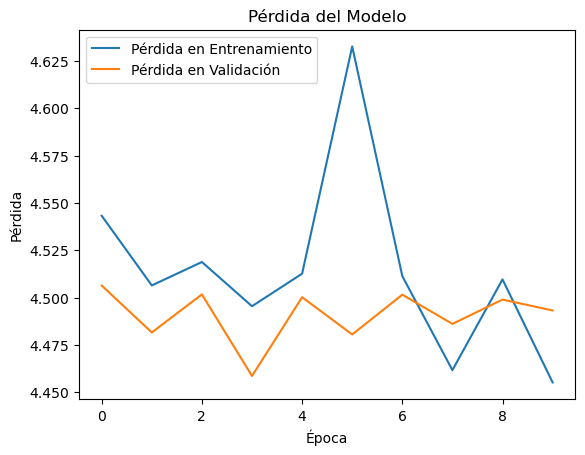

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

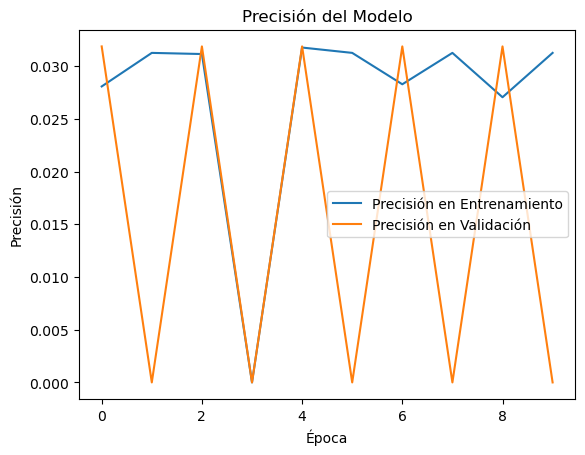

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()